![](img/concurrencia_ib.png)

Hasta ahora hemos creado programas que se ejecutan **secuencialmente**: siguiendo el flujo de ejecución definido por el código, las instrucciones se ejecutaban siempre una detrás de la otra, esperando a que finalice cada instrucción para empezar a ejecutar la siguiente. Ahora bien, por un lado, la mayoría de los ordenadores modernos disponen de varias CPU, lo que permite ejecutar varios flujos de ejecución al mismo tiempo. Por otra parte, aunque solo dispongamos de una única CPU, a veces será más eficiente ir intercalando la ejecución de varios hilos, en vez de ir esperando a que finalice cada uno de ellos para ejecutar el siguiente. Es el caso, por ejemplo, de hilos de ejecución que esperan a eventos externos: mientras uno de los hilos se encuentra esperando al evento externo, un segundo hilo puede aprovechar la CPU para hacer cálculos.

Así, en este notebook describiremos cómo podemos realizar programación **concurrente** (en la que diversas tareas pueden avanzar simultáneamente, sin necesidad de esperar a que finalice una para iniciar la siguiente) y programación **paralela** (en la cual varias tareas se ejecutan a la vez) en Python. La imagen siguiente muestra el concepto clave que distingue la programación secuencial, la concurrente y la paralela:

Un **proceso** es un programa que se ha cargado en memoria para su ejecución, junto con los recursos que necesita para ejecutarse. Estos recursos contienen los registros (que pueden contener una instrucción, una dirección, un dato, etc.); el contador de programa (un registro especial que almacena un puntero a la instrucción que se está ejecutando); y la pila y el heap (con el hilo de llamadas que han ido sucediendo y las variables que se han ido creando).

Un hilo de **ejecución** o **thread** es una unidad de ejecución dentro de un proceso. Un proceso siempre tiene al menos un thread, pero puede tener varios de ellos.

## Uso de múltiples threads en Python

In [11]:
from threading import Thread
from random import randint
from time import sleep
import logging
import sys

In [2]:
def random_wait(t_index):
    """
    Espera un tiempo aleatorio entre 1 y 4 segundos.
    """
    logging.info("[T{}]\tStarted".format(t_index))
    t = randint(4, 6)
    logging.info("[T{}]\tSleeping {} seconds...".format(t_index, t))
    sleep(t)
    logging.info("[T{}]\tEnd".format(t_index))

In [12]:
# Configura el logging
log_format = '[%(process)d]\t%(asctime)s %(levelname)s: %(message)s'
logging.basicConfig(format=log_format, level=logging.INFO, datefmt="%H:%M:%S",
                    handlers=[logging.StreamHandler(sys.stdout)])

In [7]:
# Creamos 3 threads que ejecutan la función random_wait
threads = []
num_threads = 3

logging.info("[M]\tScript Initialized!")  
for i in range(num_threads):
    logging.info("[M]\tCreating threads {}".format(i))
    # Creamos el thread
    thread = Thread(target=random_wait, args=(i,))
    threads.append(thread)
    # Ejecutamos el thread
    thread.start()

# Espera que los 3 thread finalicen
for i, thread in enumerate(threads):
    logging.info("[M]\tWaiting to join thread {}".format(i))
    thread.join()
    logging.info("[M]\tThread {} joined!".format(i))

logging.info("[M]\tDONE!")   

[37008]	13:36:30 INFO: [M]	Script Initialized!
[37008]	13:36:30 INFO: [M]	Creating threads 0
[37008]	13:36:30 INFO: [T0]	Started
[37008]	13:36:30 INFO: [M]	Creating threads 1
[37008]	13:36:30 INFO: [T0]	Sleeping 4 seconds...
[37008]	13:36:30 INFO: [T1]	Started
[37008]	13:36:30 INFO: [M]	Creating threads 2
[37008]	13:36:30 INFO: [T1]	Sleeping 4 seconds...
[37008]	13:36:30 INFO: [T2]	Started
[37008]	13:36:30 INFO: [M]	Waiting to join thread 0
[37008]	13:36:30 INFO: [T2]	Sleeping 6 seconds...
[37008]	13:36:34 INFO: [T1]	End
[37008]	13:36:34 INFO: [T0]	End
[37008]	13:36:34 INFO: [M]	Thread 0 joined!
[37008]	13:36:34 INFO: [M]	Waiting to join thread 1
[37008]	13:36:34 INFO: [M]	Thread 1 joined!
[37008]	13:36:34 INFO: [M]	Waiting to join thread 2
[37008]	13:36:36 INFO: [T2]	End
[37008]	13:36:36 INFO: [M]	Thread 2 joined!
[37008]	13:36:36 INFO: [M]	DONE!


## Optimización de código usando threads en Python

No todos los programas pueden beneficiarse de la ejecución en múltiples threads. Por un lado, los programas que requieren conocer unos resultados anteriores para calcular los siguientes difícilmente se ejecutarán más rápido en un entorno multithreaded, ya que los diferentes hilos no podrán ejecutarse concurrentemente. Por otro lado, en su versión más extendida, Python ejecuta los diferentes threads en un mismo procesador, por lo que la ejecución de estos es concurrente (pero no paralela). Veámoslo con un par de ejemplos.

In [4]:
from sympy import primefactors


def get_factors(t_index, value):
    """
    Devuelve la factorización de `value` en factores primos.
    """
    logging.info("[T{}]\tStarted with input {}".format(t_index, value))
    r = primefactors(value)
    logging.info("[T{}]\tEnded with output {}".format(t_index, r))

In [5]:
# Factoriza el valor 15
get_factors(1, 15)

[35460]	13:43:20 INFO: [T1]	Started with input 15
[35460]	13:43:20 INFO: [T1]	Ended with output [3, 5]


Ahora, vamos a calcular la factorización de tres enteros utilizando la función *get_factors* de **manera secuencial**:

In [6]:
nums_to_factor = [5215785878052641903952977068511001599,
                  748283119772062608265951220534384001023,
                  949273031776466197045163567568010291199]

In [9]:
%%time

for _, num in enumerate(nums_to_factor):
    get_factors(_, num)

[35460]	13:50:43 INFO: [T0]	Started with input 5215785878052641903952977068511001599
[35460]	13:50:43 INFO: [T0]	Ended with output [479001599, 10888869450418352160768000001]
[35460]	13:50:43 INFO: [T1]	Started with input 748283119772062608265951220534384001023
[35460]	13:50:44 INFO: [T1]	Ended with output [68720001023, 10888869450418352160768000001]
[35460]	13:50:44 INFO: [T2]	Started with input 949273031776466197045163567568010291199
[35460]	13:50:48 INFO: [T2]	Ended with output [87178291199, 10888869450418352160768000001]
CPU times: total: 5.28 s
Wall time: 5.56 s


 A continuación volveremos a repetir el cálculo de la factorización de los mismos tres enteros, ejecutándolos ahora como **threads** independientes:

In [8]:
%%time
threads = []

# Crea 3 threads que ejecutan la función get_factors y
# los inicia
for i, num in enumerate(nums_to_factor):
    thread = Thread(target=get_factors, args=(i, num))
    threads.append(thread)
    thread.start()

# Espera a que los 3 threads finalicen
for i, thread in enumerate(threads):
    logging.info("[M]\tWaiting to join thread {}".format(i))
    thread.join()
    logging.info("[M]\tThread {} joined!".format(i))

logging.info("[M]\tDONE!")

[35460]	13:50:19 INFO: [T0]	Started with input 5215785878052641903952977068511001599
[35460]	13:50:19 INFO: [T1]	Started with input 748283119772062608265951220534384001023
[35460]	13:50:19 INFO: [T2]	Started with input 949273031776466197045163567568010291199
[35460]	13:50:19 INFO: [M]	Waiting to join thread 0
[35460]	13:50:22 INFO: [T0]	Ended with output [479001599, 10888869450418352160768000001]
[35460]	13:50:22 INFO: [M]	Thread 0 joined!
[35460]	13:50:22 INFO: [M]	Waiting to join thread 1
[35460]	13:50:25 INFO: [T1]	Ended with output [68720001023, 10888869450418352160768000001]
[35460]	13:50:25 INFO: [M]	Thread 1 joined!
[35460]	13:50:25 INFO: [M]	Waiting to join thread 2
[35460]	13:50:25 INFO: [T2]	Ended with output [87178291199, 10888869450418352160768000001]
[35460]	13:50:25 INFO: [M]	Thread 2 joined!
[35460]	13:50:25 INFO: [M]	DONE!
CPU times: total: 6.42 s
Wall time: 6.68 s


 * Los tiempos de ejecución de las dos versiones del código (la primera, secuencial, y la segunda, con múltiples threads) es muy similar (y, a menudo, la versión secuencial resulta más rápida).

* Vemos ahora un segundo ejemplo, en el que crearemos también tres threads: dos de ellos se descargarán unos conjuntos de datos de internet, y el tercero volverá a factorizar uno de los números del ejemplo anterior.

En primer lugar, definimos la función `get_url_and_write_to_disk`, que descarga el contenido de una URL y lo guarda en el disco:

In [12]:
import requests


def get_url_and_write_to_disk(t_index, url):
    """
    Descarga el contenido de la url y lo guarda en la carpeta `data`.
    """
    logging.info("[T{}]\tStarted with url {}".format(t_index, url))
    r = requests.get(url, allow_redirects=True)
    open('data/'+str(t_index), 'wb').write(r.content)
    logging.info("[T{}]\tEnd".format(t_index))

urls = ["https://snap.stanford.edu/data/twitter.tar.gz",
        "https://snap.stanford.edu/data/twitter_combined.txt.gz"]



Ahora, como en el ejemplo anterior, ejecutaremos las tres tareas de manera secuencial: primero, factorizaremos el entero y, después, descargaremos los dos ficheros apuntados por las URL de la lista de la celda anterior:

In [13]:
%%time

get_factors(1, nums_to_factor[-1])

[35460]	13:57:59 INFO: [T1]	Started with input 949273031776466197045163567568010291199
[35460]	13:58:00 INFO: [T1]	Ended with output [87178291199, 10888869450418352160768000001]
CPU times: total: 344 ms
Wall time: 479 ms


In [17]:
%%time

for url in urls:
    get_url_and_write_to_disk(1, url)

[35460]	14:01:07 INFO: [T1]	Started with url https://snap.stanford.edu/data/twitter.tar.gz
[35460]	14:01:13 INFO: [T1]	End
[35460]	14:01:13 INFO: [T1]	Started with url https://snap.stanford.edu/data/twitter_combined.txt.gz
[35460]	14:01:19 INFO: [T1]	End
CPU times: total: 703 ms
Wall time: 12.3 s


A continuación, implementamos la versión **multithreaded** del código anterior, creando tres threads (dos que descargarán archivos y uno que hará el cálculo de la factorización).

In [18]:
%%time

# Creamos los 3 threads que ejecutan get_factors o get_url_and_write_to_disk
# y los iniciamos
threads = []
for i in range(3):
    if i == 2:
        thread = Thread(target=get_factors, args=(i, nums_to_factor[-1]))
    else:
        thread = Thread(target=get_url_and_write_to_disk, args=(i, urls[i]))
        
    threads.append(thread)
    thread.start()

# Esperamos a que los 3 threads finalicen
for i, thread in enumerate(threads):
    logging.info("[M]\tWaiting to join thread {}".format(i))
    thread.join()
    logging.info("[M]\tThread {} joined!".format(i))

logging.info("[M]\tDONE!")

[35460]	14:01:34 INFO: [T0]	Started with url https://snap.stanford.edu/data/twitter.tar.gz
[35460]	14:01:34 INFO: [T1]	Started with url https://snap.stanford.edu/data/twitter_combined.txt.gz
[35460]	14:01:34 INFO: [T2]	Started with input 949273031776466197045163567568010291199
[35460]	14:01:34 INFO: [M]	Waiting to join thread 0
[35460]	14:01:36 INFO: [T2]	Ended with output [87178291199, 10888869450418352160768000001]
[35460]	14:01:40 INFO: [T1]	End
[35460]	14:01:43 INFO: [T0]	End
[35460]	14:01:43 INFO: [M]	Thread 0 joined!
[35460]	14:01:43 INFO: [M]	Waiting to join thread 1
[35460]	14:01:43 INFO: [M]	Thread 1 joined!
[35460]	14:01:43 INFO: [M]	Waiting to join thread 2
[35460]	14:01:43 INFO: [M]	Thread 2 joined!
[35460]	14:01:43 INFO: [M]	DONE!
CPU times: total: 2.78 s
Wall time: 8.86 s


## Multiplese procesos

En esta sección veremos cómo podemos crear múltiples procesos desde nuestro código en Python. De hecho, ya hemos creado procesos desde Python anteriormente, cuando ejecutábamos programas externos utilizando el módulo subprocess. 

En ese caso, simplemente creábamos un nuevo proceso que ejecutaba un comando del sistema operativo o bien algún programa externo a nuestro código Python, y esperábamos a que finalizara para seguir la ejecución del proceso principal (que ejecutaba nuestro programa en Python). Ahora, veremos cómo podemos crear varios procesos que ejecutan código de nuestro programa en Python de manera paralela, utilizando el módulo multiprocessing.El módulo **multiprocessing** implementa la clase Process, que representa un flujo de ejecución que corre en un proceso individual. 

Para crear diferentes procesos controlados por nuestro programa principal, crearemos pues diferentes instancias de la **clase Process**, especificando qué función han de ejecutar y con qué parámetros.De manera similar a como trabajábamos con los threads en el apartado anterior, una vez creada la instancia de Process, podemos iniciar su ejecución llamando al método start, y esperar a su finalización con el método join.A continuación se implementa un ejemplo sencillo (análogo al primer ejemplo de multithreading) de ejecución multiproceso con el módulo multiprocessing.

In [21]:
%%time
from multiprocessing import Process

def random_wait(p_index):
    """
    Espera un tiempo aleatorio entre 1 y 4 segundos.
    """
    logging.info("[P{}]\tStarted".format(p_index))
    t = randint(1, 4)
    logging.info("[P{}]\tSleeping {} seconds...".format(p_index, t))
    sleep(t)
    logging.info("[P{}]\tEnd".format(p_index))


# Crea 3 procesos que ejecutan la función random_wait y
# los inicia
processes = []
for i in range(3):
    logging.info("[M]\tCreating process {}".format(i))
    # Crea el proceso
    p = Process(target=random_wait, args=(i,))
    processes.append(p)
    # Inicia el proceso
    p.start()

# Espera a que los 3 procesos finalicen
for i, process in enumerate(processes):
    logging.info("[M]\tWaiting to join process {}".format(i))
    process.join()
    logging.info("[M]\tProcess {} joined!".format(i))

logging.info("[M]\tDONE!")

[35460]	14:07:50 INFO: [M]	Creating process 0
[35460]	14:07:50 INFO: [M]	Creating process 1
[35460]	14:07:50 INFO: [M]	Creating process 2
[35460]	14:07:50 INFO: [M]	Waiting to join process 0
[35460]	14:07:50 INFO: [M]	Process 0 joined!
[35460]	14:07:50 INFO: [M]	Waiting to join process 1
[35460]	14:07:50 INFO: [M]	Process 1 joined!
[35460]	14:07:50 INFO: [M]	Waiting to join process 2
[35460]	14:07:50 INFO: [M]	Process 2 joined!
[35460]	14:07:50 INFO: [M]	DONE!
CPU times: total: 46.9 ms
Wall time: 254 ms


Aunque la gestión de los procesos se ha hecho de manera muy similar a como habíamos gestionado los threads, ¡la ejecución es muy diferente! Por un lado, los diferentes procesos pueden **ejecutarse en paralelo**, distribuyendo su ejecución entre las diversas CPU de la máquina. 

Por otra parte, la **gestión de la memoria** ha sido radicalmente diferente: con la creación de varios procesos, se han creado copias de todos los recursos para cada uno de ellos.Uno de los primeros cambios que podemos observar de la salida de la celda anterior es que ahora el identificador de proceso (el PID, que es el primer valor que se muestra entre corchetes en cada línea de log) es ahora diferente para cada uno de los procesos, ya que, efectivamente, se han creado procesos independientes, que disponen de su propio identificador de proceso.

## Práctica a realizar

A continuación encontraréis un conjunto de problemas que os pueden servir para practicar los conceptos explicados en esta unidad. Os recomendamos que intentéis realizar estos problemas vosotros mismos y que, una vez realizados, comparéis la solución que proponemos con la vuestra. No dudéis en dirigir todas las dudas que surjan o bien de la resolución de estos ejercicios o bien de las soluciones propuestas en el foro del aula.

- En esta actividad intentaremos ver gráficamente si hay alguna correlación entre las coordenadas geográficas de un país y el número de defunciones por Covid-19 que se han reportado. Para ello, utilizaremos, por un lado, los datos sobre Covid-19 recopilados por el European Center for Disease Prevention and Control (ECDC) y, por otro lado, **una API externa para obtener la localización geográfica de los países.**

El objetivo de la actividad es generar un scatter plot con el número de defunciones de cada país del que tenemos datos y la posición geográfica de este país:

* Cada punto del plot representará un país.
* Los ejes x e y del plot representarán las coordenadas geográficas del país.
* El tamaño del punto representará el número de defunciones.

Los datos de defunciones de cada país se pueden obtener del dataset del ECDC, que encontraréis en data/COVID-19.csv. Los datos de localización geográfica de cada país no se encuentran en el dataset y habrá que obtenerlos utilizando alguna API externa de geolocalización (podéis elegir la API que utilizaréis).


* 1.1. Implementad un programa **multiproceso** que genere el scatter plot especificado. Para hacerlo, pensad qué tareas se pueden paralelizar y qué herramientas podéis utilizar para coordinar los diferentes procesos.

In [5]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

from multiprocessing import Process
from multiprocessing import JoinableQueue, Queue

`https://api.opencagedata.com/geocode/v1/json?q={}&key={}`

In [6]:
def get_geo_coords(country_name):
    api_key = "300595568e734839a77c490e4fecd0fd"
    base_url = "https://api.opencagedata.com/geocode/v1/json?q={}&key={}"

    try:
        response = requests.get(base_url.format(country_name, api_key))
        r = response.json()
        lat = r['results'][0]['geometry']['lat']
        lng = r['results'][0]['geometry']['lng']
    except Exception as e:
        lat, lng = 0, 0
    
    return lat, lng

In [7]:
get_geo_coords("Italy")

(42.6384261, 12.674297)

In [5]:
def get_coords_proc(p_index, countries_q, results_q):
    """
    Obtiene tareas (países de los que queremos saber las coordenadas)
        de la cola `countries_q`, realiza las tareas y guarda los
        resultados en la cola `results_q`.

    Finaliza cuando ya no hay tareas por realizar.
    """
    logging.info("[P{}]\tStarted".format(p_index))

    # Obtenemos la primera tarea
    country = countries_q.get()
    # Mientras haya tareas pendientes, las realizamos
    while country:
        logging.info("[P{}]\tStarting to work on {}".format(p_index, country))
        r = get_geo_coords(country)
        logging.info("[P{}]\tResult is {}".format(p_index, r))
        # Guardamos el resultado en la cola results_q
        results_q.put([country, r])
        # Indicamos que hemos finalizado la tarea
        countries_q.task_done()
        # Obtenemos la próxima tarea
        country = countries_q.get()

    logging.info("[P{}]\tEnding".format(p_index))
    # Indicamos que hemos finalizado la última tarea obtenida de la cola
    # (que era None, el marcador de final de tareas)
    countries_q.task_done()
    logging.info("[P{}]\tProcess ended".format(p_index))

In [6]:


def get_coords_multiproc(countries, num_processes):
    """
    Obtiene las coordenadas geográficas de una lista de países, utilizando
        `num_processes` procesos independientes para la obtención de los datos.
    """
    # Creamos la cola de resultados
    results_q = Queue()
    # Creamos la cola de tareas por realizar
    countries_q = JoinableQueue()
    # Añadimos los países a la cola de tareas
    for country in countries:
        countries_q.put(country)

    # Añadimos un indicador de final de proceso al final de la lista
    # de tareas para cada proceso
    for _ in range(num_processes):
        countries_q.put(None)

    # Iniciamos los `num_processes` procesos con la tarea de obtener
    # las coordenadas y pasando las colas como parámetros
    for i in range(num_processes):
        process = Process(target=get_coords_proc,
                          args=(i, countries_q, results_q))
        process.start()

    # Esperamos a que se hayan completado todas las tareas
    logging.info("[M]\tWaiting to join processes")
    countries_q.join()
    logging.info("[M]\tProcesses joined!")
    r_list = {}
    while not results_q.empty():
        e = results_q.get()
        r_list[e[0]] = e[1]

    return r_list




In [ ]:
def plot_results(deaths_by_country, countries_coords):
    """
    Genera el scatter plot con los resultados.
    """
    plt.figure()
    x, y, d = zip(*[(v[0], v[1], deaths_by_country[k])
                    for k, v in countries_coords.items()])
    plt.scatter(x, y, s=d, alpha=0.7)

In [9]:
%%time

data = pd.read_csv("data/COVID-19.csv")

# Sumamos las defunciones por país
deaths_by_country = data.groupby(['countriesAndTerritories'])['deaths'].sum()

# Obtenemos la coordenada
countries_coords = get_coords_multiproc(deaths_by_country.index, num_processes=4)

# Mostramos los resultados
plot_results(deaths_by_country, countries_coords)

[30604]	14:40:32 INFO: [M]	Waiting to join processes


* 1.2. Implementad un programa **multithreaded** que genere el scatter plot especificado. Para hacerlo, pensad qué tareas pueden ejecutarse en diferentes threads y qué herramientas podéis utilizar para evitar las interferencias entre los threads. 

En este caso, utilizaremos una implementación similar a la versión multiproceso:

Mantendremos el uso de la JoinableQueue para coordinar las tareas de los diferentes procesos.No necesitaremos usar una cola de resultados, ya que los threads comparten variables. Por lo tanto, vamos a crear directamente un diccionario de resultados countries_coords y los threads escribirán directamente los resultados que vayan obteniendo. Usaremos un `lock` para evitar interferencias en la actualización del diccionario.

In [8]:
def get_coords_thr(t_index, countries_q, lock, countries_coords):
    """
    Obtiene tareas (países de los que queremos saber las coordenadas)
        de la cola `countries_q`, realiza las tareas y guarda los
        resultados en el diccionario `countries_coords`.

    Finaliza cuando ya no hay tareas por realizar.
    """
    logging.info("[T{}]\tStarted".format(t_index))

    # Obtenemos la primera tarea
    country = countries_q.get()
    # Mientras haya tareas pendientes, las realizamos
    while country:
        logging.info("[T{}]\tStarting to work on {}".format(t_index, country))
        r = get_geo_coords(country)
        logging.info("[T{}]\tResult is {}".format(t_index, r))
        
        # Guardamos el resultado en el diccionario de resultados, obteniendo
        # primero el lock y liberándolo cuando acabemos la actualización
        lock.acquire()
        countries_coords[country] = r
        lock.release()
        # Indicamos que hemos finalizado la tarea
        countries_q.task_done()
        # Obtenemos la próxima tarea
        country = countries_q.get()

    logging.info("[T{}]\tEnding".format(t_index))
    # Indicamos que hemos finalizado la última tarea obtenida de la cola
    # (que era None, el marcador de final de tareas)
    countries_q.task_done()
    logging.info("[T{}]\tThread ended".format(t_index))

In [9]:
def get_coords_multithr(countries, num_threads, lock, countries_coords):
    """
    Obtiene las coordenadas geográficas de una lista de países, utilizando
        `num_threads` threads para la obtención de los datos.
    """

    # Creamos la cola de tareas que realizar
    countries_q = JoinableQueue()
    # Añadimos los países a la cola de tareas
    for country in countries:
        countries_q.put(country)

    # Añadimos un indicador de final de tarea al final de la lista
    # de tareas para cada thread
    for _ in range(num_threads):
        countries_q.put(None)

    # Iniciamos los `num_threads` hilos con la tarea de obtener
    # las coordenadas y pasando la cola como parámetro
    for i in range(num_threads):
        thread = Thread(target=get_coords_thr,
                        args=(i, countries_q, lock, countries_coords))
        thread.start()

    # Esperamos a que se hayan completado todas las tareas
    logging.info("[M]\tWaiting to join threads")
    countries_q.join()
    logging.info("[M]\tThreads joined!")

In [14]:
def plot_results(deaths_by_country, countries_coords):
    """
    Genera el scatter plot con los resultados.
    """
    plt.figure()
    x, y, d = zip(*[(v[0], v[1], deaths_by_country[k])
                    for k, v in countries_coords.items()])
    plt.scatter(x, y, s=d, alpha=0.7)

[38156]	14:48:31 INFO: [T0]	Started
[38156]	14:48:31 INFO: [T1]	Started
[38156]	14:48:31 INFO: [T2]	Started
[38156]	14:48:31 INFO: [T3]	Started
[38156]	14:48:31 INFO: [M]	Waiting to join threads
[38156]	14:48:31 INFO: [T0]	Starting to work on Afghanistan
[38156]	14:48:31 INFO: [T1]	Starting to work on Albania
[38156]	14:48:31 INFO: [T2]	Starting to work on Algeria
[38156]	14:48:31 INFO: [T3]	Starting to work on Andorra
[38156]	14:48:31 INFO: [T1]	Result is (41.000028, 19.9999619)
[38156]	14:48:31 INFO: [T0]	Result is (33.7680065, 66.2385139)
[38156]	14:48:31 INFO: [T1]	Starting to work on Angola
[38156]	14:48:31 INFO: [T0]	Starting to work on Anguilla
[38156]	14:48:31 INFO: [T2]	Result is (28.0000272, 2.9999825)
[38156]	14:48:31 INFO: [T2]	Starting to work on Antigua_and_Barbuda
[38156]	14:48:31 INFO: [T3]	Result is (42.5407167, 1.5732033)
[38156]	14:48:31 INFO: [T3]	Starting to work on Argentina
[38156]	14:48:31 INFO: [T2]	Result is (17.05, -61.8)
[38156]	14:48:31 INFO: [T0]	Result is

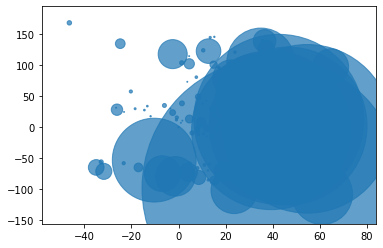

In [15]:
%%time


from threading import Lock

# Cargamos los datos del fichero Covid-19
data = pd.read_csv("data/COVID-19.csv")
# Sumamos las defunciones por país
deaths_by_country = data.groupby(["countriesAndTerritories"])["deaths"].sum()
# Obtenemos las coordenadas, paralelizando el trabajo con 4 threads
lock = Lock()
countries_coords = {}
get_coords_multithr(deaths_by_country.index, 4, lock, countries_coords) 
# Mostramos los resultados
plot_results(deaths_by_country, countries_coords)